In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3

# Driver Data Processing
This notebook calculates the statistics used to describe each driver in the clustering.

Developed by Siobhan Powell, 2021. 

In [ ]:
s3_data_location = '' # fill in with own data folder

In [2]:
# missing september data in 2019
weekdays_ct = {'2015':5*52+1, '2016':5*52+1, '2017':5*52, '2018':5*52+1, '2019':(5*52+1)-(5*4+1), '2020':5*52+2}
weekends_ct = {'2015':2*52, '2016':2*52+1, '2017':2*52+1, '2018':2*52, '2019': (2*52)-(2*4+1), '2020':2*52}

# Use 2019 data
year = '2019'
data = pd.read_csv(s3_data_location+'sessions'+year+'.csv', index_col=0)

print('Num sessions: ', len(data))
drivers = list(set(data['Driver ID']))
print('Num drivers: ', len(drivers))

2019


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Num sessions:  6092256
Num drivers:  118978


## Cleaning
Remove data with impossible battery capacity label; keep only plugin EVs, not hybrids

In [3]:
data['EV Type'].isna().sum() / len(data)

0.49746924620370514

In [4]:
data['EV Type'].value_counts()

PLUGIN    2373946
HYBRID     687600
Name: EV Type, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


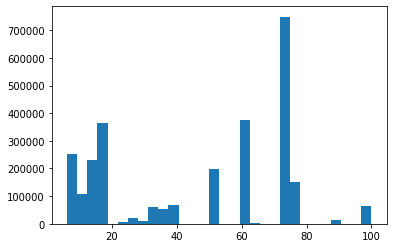

In [5]:
plt.hist(data[data['EV Type'].isna()]['Battery Capacity'], 30)
plt.show()

In [11]:
keep_drivers1 = []
keep_drivers2 = []
all_drivers = list(set(data['Driver ID']))
print('Total number of drivers: ', len(all_drivers))
for i in range(len(all_drivers)):
    if np.mod(i, 10000) == 0:
        print('On driver ', i)
    driver = all_drivers[i]
    subsub = data[data['Driver ID']==driver]
    if subsub['Energy (kWh)'].max() <= subsub['Battery Capacity'].min():
        keep_drivers1.append(driver)
        if len(list(set(subsub['EV Type']))) > 1:
            if 'HYBRID' in list(set(subsub['EV Type'])):
                donothing=1
            elif 'PLUGIN' in list(set(subsub['EV Type'])):
                keep_drivers2.append(driver)
        else:
            if subsub['EV Type'].values[0] == 'PLUGIN':
                keep_drivers2.append(driver)
            elif subsub['EV Type'].isna().sum() > 0:
                if subsub['Battery Capacity'].min() > 20:
                    keep_drivers2.append(driver)

print('Keeping fraction: ', len(keep_drivers1) / len(drivers))
print('Keeping fraction: ', len(keep_drivers2) / len(drivers))

Total number of drivers:  118978
On driver  0
On driver  10000
On driver  20000
On driver  30000
On driver  40000
On driver  50000
On driver  60000
On driver  70000
On driver  80000
On driver  90000
On driver  100000
On driver  110000
Keeping fraction:  0.8077459698431643
Keeping fraction:  0.6173326161139034


In [12]:
len(keep_drivers2)

73449

## Calculate statistics

In [13]:
driver_stats = pd.DataFrame({'Unique Driver ID':[0]}, index=[0])

weekdays_2019 = weekdays_ct[year]
weekends_2019 = weekends_ct[year]

i = 0
for ct in range(len(keep_drivers2)):
    driver = keep_drivers2[ct] 
    subset = data[data['Driver ID']==driver]
    subset = subset.sort_values(by='start_day')
    if len(subset) >= 25:

        driver_stats.loc[i, 'Unique Driver ID'] = driver

        driver_stats.loc[i, 'Num Sessions'] = len(subset)
        driver_stats.loc[i, 'Num Zip Codes'] = len(set(subset['Zip Code']))
        driver_stats.loc[i, 'Battery Capacity'] = min(list(set(subset['Battery Capacity'])))
        
        driver_stats.loc[i, 'Total Energy'] = subset['Energy (kWh)'].sum()
        driver_stats.loc[i, 'Total Energy - weekday'] = subset[subset['start_weekday'].isin([0, 1, 2, 3, 4])]['Energy (kWh)'].sum()
        driver_stats.loc[i, 'Total Energy - weekend'] = subset[subset['start_weekday'].isin([5, 6])]['Energy (kWh)'].sum()

        wp_set = subset[subset['POI Category']=='Workplace']
        res_set = subset[subset['POI Category']=='Single family residential']
        mud_set = subset[subset['POI Category']=='Multifamily Home Service']
        other_set = subset[subset['POI Category'].isin(['Education', 'Utility', 'Retail', 'Parking', 'Healthcare', 'Municipal', 'Multifamily Commercial', 'Parks and Recreation', 'Hospitality', 'Government (Fed, State)'])]
        other_slow_set = other_set[other_set['Max Power']<20]
        other_fast_set = other_set[other_set['Max Power']>=20]

        driver_stats.loc[i, 'Num Workplace Sessions'] = len(wp_set)
        driver_stats.loc[i, 'Num Single Family Residential Sessions'] = len(res_set)
        driver_stats.loc[i, 'Num MUD Sessions'] = len(mud_set)
        driver_stats.loc[i, 'Num Other Slow Sessions'] = len(other_slow_set)
        driver_stats.loc[i, 'Num Other Fast Sessions'] = len(other_fast_set)

        loc_dict = {'Home':res_set, 'Work':wp_set, 'Other Slow':other_slow_set, 'Other Fast':other_fast_set, 'MUD':mud_set}
        for location in ['Work', 'Home', 'Other Slow', 'Other Fast', 'MUD']:
            subsub = loc_dict[location]
            if len(subsub) > 0:
                driver_stats.loc[i, location+' - Session energy - mean'] = subsub['Energy (kWh)'].mean()
                driver_stats.loc[i, location+' - Session time - mean'] = ((1/3600)*(subsub['Session Time (secs)'])).mean()
                driver_stats.loc[i, location+' - Start hour - mean'] = ((1/3600)*(subsub['start_seconds'])).mean()

                weekday_subsub = subsub[subsub['start_weekday'].isin([0, 1, 2, 3, 4])]
                weekend_subsub = subsub[subsub['start_weekday'].isin([5, 6])]
                
                driver_stats.loc[i, location+' - Session energy - mean - weekday'] = weekday_subsub['Energy (kWh)'].mean()
                driver_stats.loc[i, location+' - Session time - mean - weekday'] = ((1/3600)*(weekday_subsub['Session Time (secs)'])).mean()
                driver_stats.loc[i, location+' - Start hour - mean - weekday'] = ((1/3600)*(weekday_subsub['start_seconds'])).mean()
                driver_stats.loc[i, location+' - Num Sessions - weekday'] = len(weekday_subsub)
                driver_stats.loc[i, location+' - Session energy - mean - weekend'] = weekend_subsub['Energy (kWh)'].mean()
                driver_stats.loc[i, location+' - Session time - mean - weekend'] = ((1/3600)*(weekend_subsub['Session Time (secs)'])).mean()
                driver_stats.loc[i, location+' - Start hour - mean - weekend'] = ((1/3600)*(weekend_subsub['start_seconds'])).mean()
                driver_stats.loc[i, location+' - Num Sessions - weekend'] = len(weekend_subsub)
                

                driver_stats.loc[i, location+' - Weekend fraction'] = len(weekend_subsub) / len(subset)

                driver_stats.loc[i, location+' - Average sessions per weekday'] = len(weekday_subsub) / weekdays_2019
                driver_stats.loc[i, location+' - Average sessions per weekendday'] = len(weekend_subsub) / weekends_2019
                driver_stats.loc[i, location+' - Fraction of weekdays with session'] = len(set(weekday_subsub['start_day']))/weekdays_2019
                driver_stats.loc[i, location+' - Fraction of weekenddays with session'] = len(set(weekend_subsub['start_day']))/weekends_2019

            else:
                driver_stats.loc[i, location+' - Session energy - mean'] = 0
                driver_stats.loc[i, location+' - Session time - mean'] = 0
                driver_stats.loc[i, location+' - Start hour - mean'] = 0
                driver_stats.loc[i, location+' - Weekend fraction'] = 0
                driver_stats.loc[i, location+' - Average sessions per weekday'] = 0
                driver_stats.loc[i, location+' - Average sessions per weekendday'] = 0
                driver_stats.loc[i, location+' - Fraction of weekdays with session'] = 0
                driver_stats.loc[i, location+' - Fraction of weekenddays with session'] = 0
                driver_stats.loc[i, location+' - Session energy - mean - weekday'] = 0
                driver_stats.loc[i, location+' - Session time - mean - weekday'] = 0
                driver_stats.loc[i, location+' - Start hour - mean - weekday'] = 0
                driver_stats.loc[i, location+' - Num Sessions - weekday'] = 0
                driver_stats.loc[i, location+' - Session energy - mean - weekend'] = 0
                driver_stats.loc[i, location+' - Session time - mean - weekend'] = 0
                driver_stats.loc[i, location+' - Start hour - mean - weekend'] = 0
                driver_stats.loc[i, location+' - Num Sessions - weekend'] = 0


        i += 1
driver_stats.to_csv(s3_data_location+'sessions'+year+'_driverdata_revised_pev_extra.csv')
print('Number of drivers:', len(driver_stats))




Number of drivers: 30272
